In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

## Get and Convert Data

In [12]:
path = Path('data/biwi_head_pose')
path.ls()[:5]

[PosixPath('data/biwi_head_pose/02'),
 PosixPath('data/biwi_head_pose/09.obj'),
 PosixPath('data/biwi_head_pose/14'),
 PosixPath('data/biwi_head_pose/21'),
 PosixPath('data/biwi_head_pose/15.obj')]

In [14]:
cal = np.genfromtxt(path / '01' / 'rgb.cal', skip_footer=6)
cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [18]:
fname = path / '09' / 'frame_00667_rgb.jpg'

In [16]:
def img2txt_name(f):
    return f'{str(f)[:-7]}pose.txt'

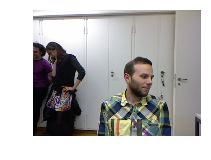

In [19]:
img = open_image(fname)
img.show()

In [20]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3)
ctr

array([187.332 ,  40.3892, 893.135 ])

In [21]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2, c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img, pts):
    return ImagePoints(FlowField(img.size, pts), scale=True)

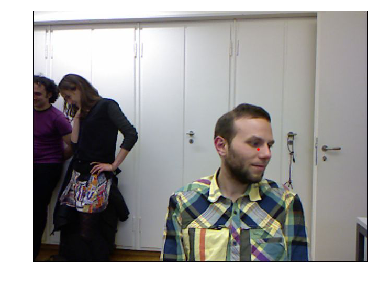

In [22]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6, 6))

## Create Custom Dataset

In [23]:
data = (ImageFileList.from_folder(path)
       .label_from_func(get_ctr)
       .split_by_valid_func(lambda o: o[0].parent.name=='13')
       .datasets(PointsDataset)
       .transform(get_transforms(), tfm_y=True, size=(120, 160))
       .databunch().normalize(imagenet_stats))

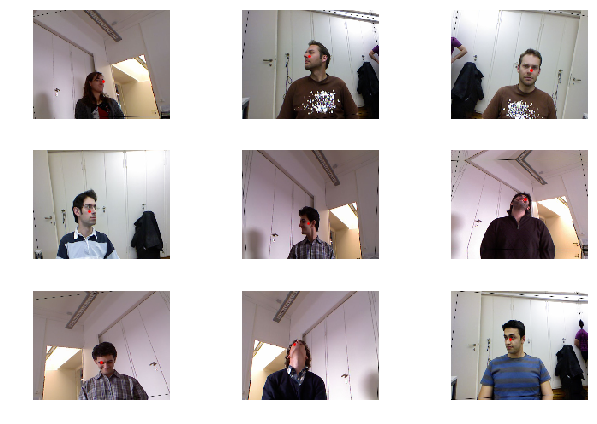

In [24]:
data.show_batch(3, figsize=(9, 6))

## Train Model

In [25]:
learn = create_cnn(data, models.resnet34)

learn.loss_func = MSELossFlat()

In [26]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


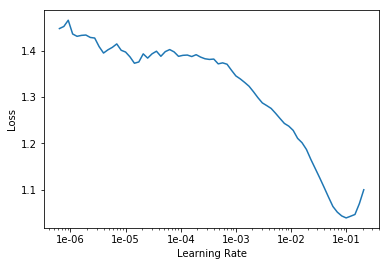

In [27]:
learn.recorder.plot()

In [28]:
lr = 2e-2

In [29]:
learn.fit_one_cycle(5, slice(lr))

Total time: 04:59
epoch  train_loss  valid_loss
1      0.037446    0.027413    (00:59)
2      0.014129    0.009182    (01:00)
3      0.004984    0.006231    (00:59)
4      0.002727    0.003616    (00:59)
5      0.002058    0.002914    (01:00)



In [30]:
learn.save('stage-1')

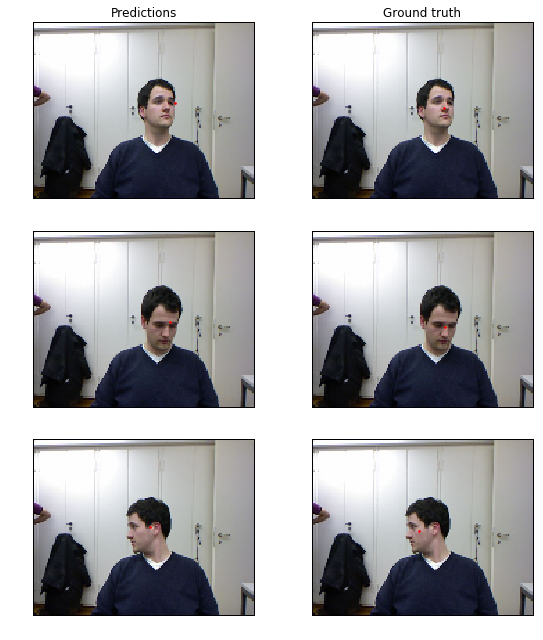

In [31]:
learn.show_results()